# Eigenfaces Case Study

In [2]:
!pip install opencv-python

In [3]:
import sys
!{sys.executable} -m pip install opencv-python

  Using cached opencv_python-4.13.0.92-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
Using cached opencv_python-4.13.0.92-cp37-abi3-macosx_13_0_arm64.whl (46.2 MB)

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip


## Imports

In [4]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA

## 1. Retrieving the images

In [5]:
url = "https://www.usfca.edu/arts-sciences/programs/undergraduate/mathematics/faculty"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

images = []
image_vectors = []

for img in soup.find_all("img"):
    src = img.get("src")
    if not src:
        continue

    img_url = urljoin(url, src)

    try:
        img_response = requests.get(img_url)
        pil_img = Image.open(BytesIO(img_response.content)).convert("L")  # grayscale
        
        pil_img = pil_img.resize((350, 350))   # all of the images are 360x360
        
        images.append(pil_img)
        image_vectors.append(np.array(pil_img).flatten())
        
    except:
        continue

images = images[1:]
image_vectors = image_vectors[1:]
X = np.array(image_vectors)

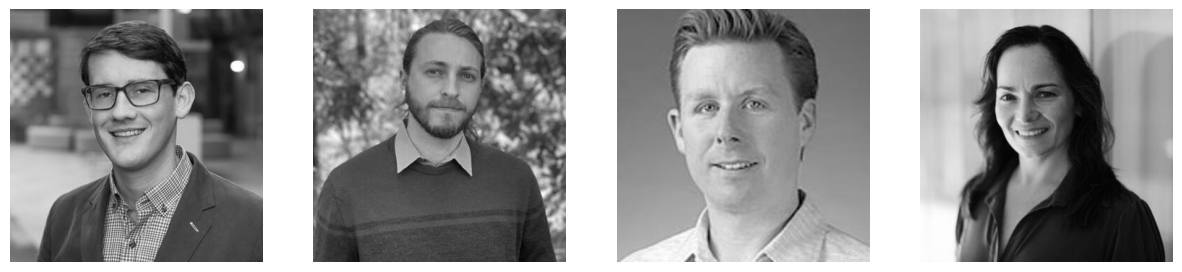

In [6]:
plt.figure(figsize=(15,15))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
    
plt.show()

## 2. Aligning the images

In [23]:
def align_face(image):
    # if image already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return None

    (x, y, w, h) = faces[0]
    face = gray[y:y+h, x:x+w]

    return cv2.resize(face, (350, 350))

def align_images(images):
    aligned_list = []

    for img in images:
        img_array = np.array(img)   # convert PIL to numpy
        aligned = align_face(img_array)

        if aligned is not None:
            aligned_list.append(aligned)

    return aligned_list

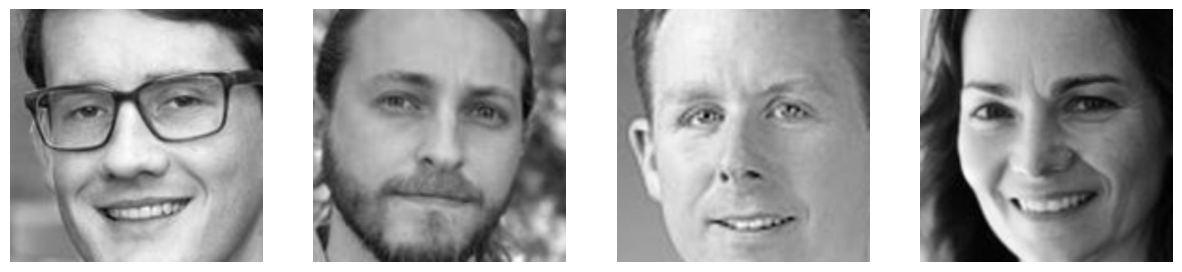

In [24]:
aligned = align_images(images)

plt.figure(figsize=(15,15))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(aligned[i], cmap="gray")
    plt.axis("off")
    
plt.show()

## Running PCA

In [25]:
mean_face = np.mean(X)
X_centered = X - mean_face

pca = PCA()
pca.fit(X_centered)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


## 3. Top eigenfaces

In [26]:
top4 = pca.components_[:4]
top4_var = pca.explained_variance_ratio_[:4]

print("Variance explained by top 4 eigenfaces:", top4_var)
print("Total variance explained:", np.sum(top4_var))

Variance explained by top 4 eigenfaces: [0.31942629 0.13673594 0.08774864 0.06911158]
Total variance explained: 0.6130224474795224


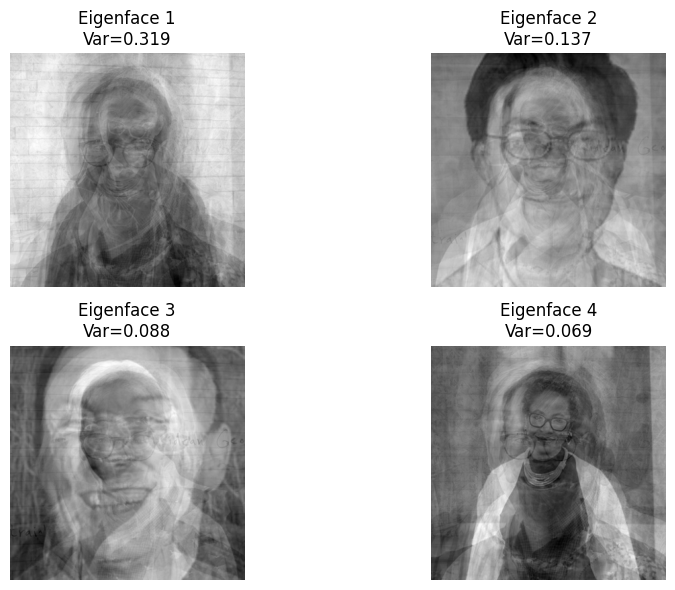

In [27]:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(top4[i].reshape(350,350), cmap="gray")
    plt.title(f"Eigenface {i+1}\nVar={top4_var[i]:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4. PCs in particular professors

In [28]:
def prof(i):
    X_centered = X - X.mean()
    pca = PCA()
    pca.fit(X_centered)
    
    x0 = X[i]
    x0_centered = x0 - X.mean()
    coeffs = pca.transform(x0_centered.reshape(1, -1))[0]
    
    PCs = [1, 2, 5, 10, 20, 21]
    plt.figure(figsize=(15, 10))
    
    for idx, pc in enumerate(PCs):
        recon = (coeffs[:pc] @ pca.components_[:pc]) + X.mean()
        plt.subplot(2, 3, idx + 1)
        plt.imshow(recon.reshape(350, 350), cmap="gray")
        plt.title(f"PCs = {pc}")
        plt.axis("off")
    
    plt.show()
    return coeffs

#### eigenfaces (PCs) Prof Wilson's picture is made up of

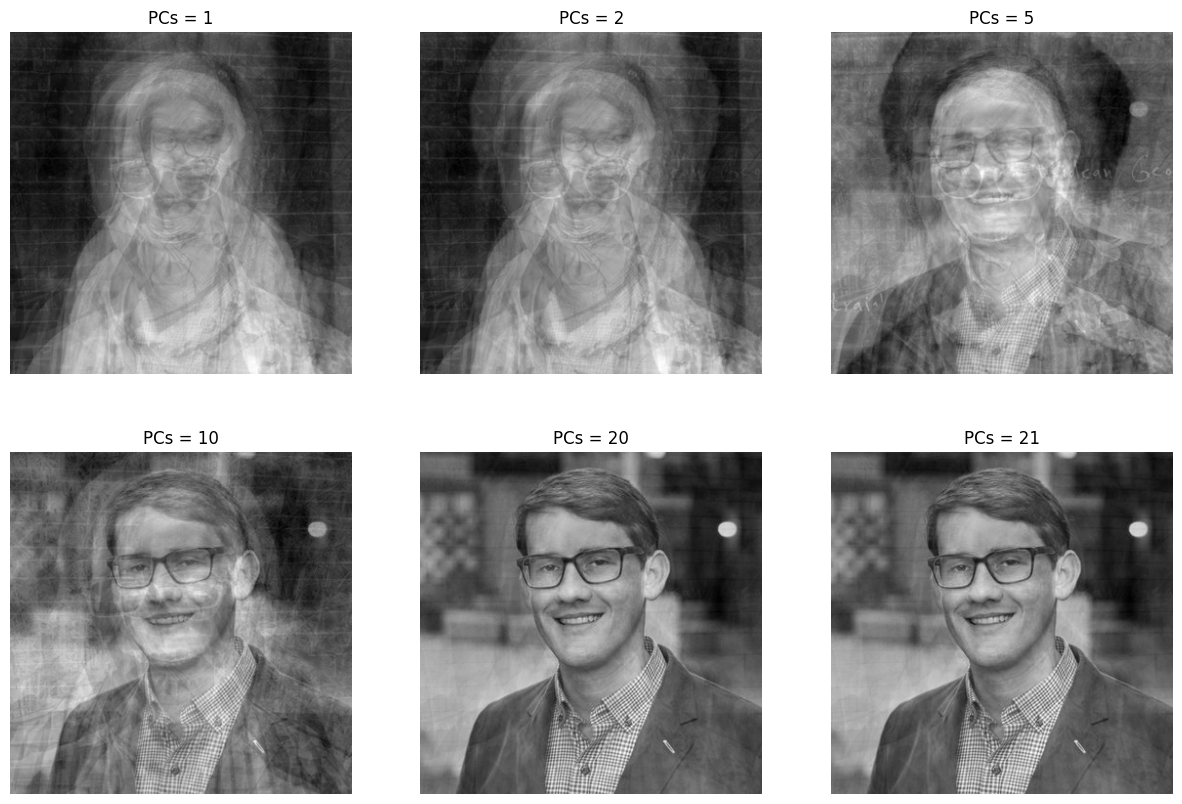

In [29]:
wilson_loadings = prof(0)

#### eigenfaces (PCs) Prof Devlin's picture is made up of

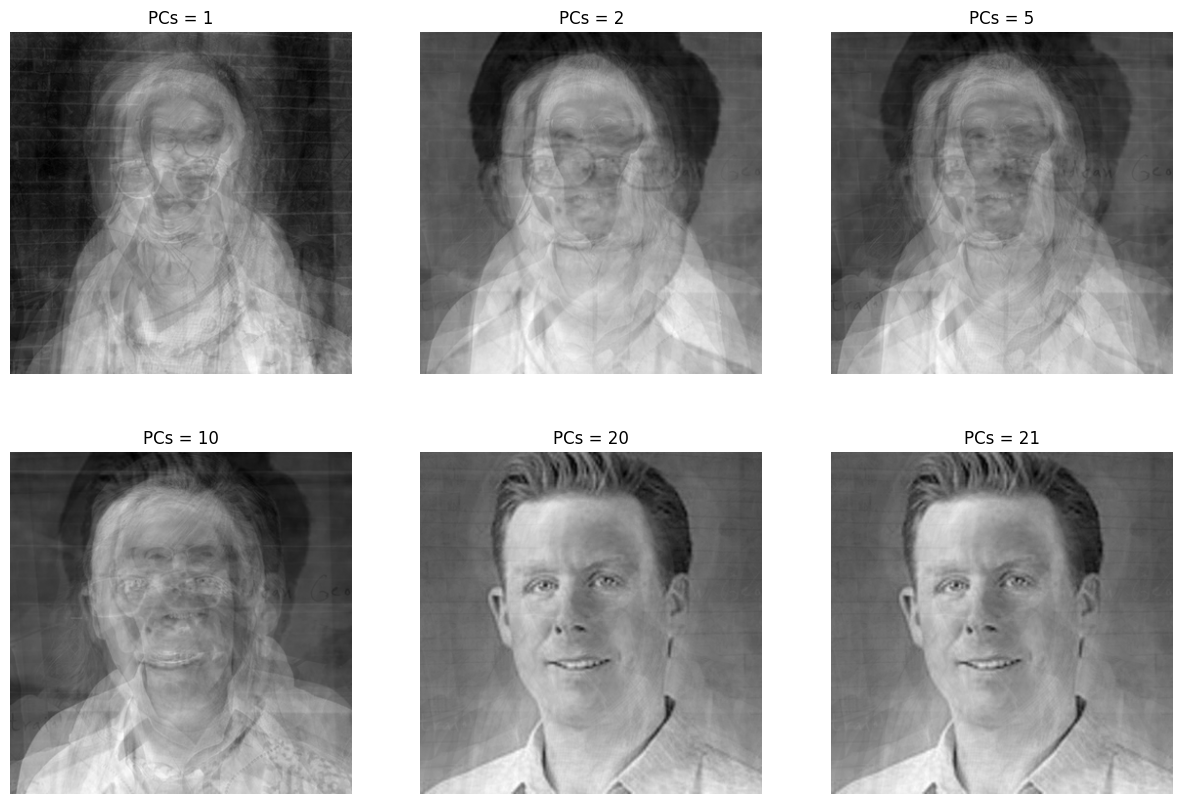

In [30]:
devlin_loadings = prof(2)

### Ext. Comparing the laodings

In [31]:
print("First 4 loadings of Prof Wilson:", wilson_loadings[:4])
print("First 4 loadings of Prof Devlin:", devlin_loadings[:4])

First 4 loadings of Prof Wilson: [-10251.5318372   -2153.54519959  -3791.39868038  -4473.50568139]
First 4 loadings of Prof Devlin: [-9715.84675231 11682.3586034    664.62034582  -451.01076104]
